In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy.table import Table, vstack
from astropy.utils.misc import isiterable


from astropy.visualization import make_lupton_rgb
plt.style.use('jpg.mplstyle')

import artpop

# need AB magnitudes to use ArtImager
zpt_convert = artpop.load_zero_point_converter()

fsps_output = '/Users/jgreco/projects/fsps/OUTPUTS/'

In [2]:
with open('/Users/jgreco/projects/fsps/data/FILTER_LIST', 'r') as f:
    lines = f.readlines()
    filter_list = []
    for l in lines:
        filter_list.append(l.split()[1])


def fetch_fsps_cmd(iso_type, log_ages=None, feh=-1.5, m_low=0.08):
    colnames = ['age', 'log(Z)', 'mini', 'mact', 'logl', 'logt', 
                'logg', 'phase', 'composition', 'log(weight)', 'log(mdot)'] + filter_list
    met = {0.0: 'p0p0', -1.5: 'm1p5'}[feh]
    mlim = {0.08: '0p08', 0.1: '0p1'}[m_low]
    fn = fsps_output + f'{iso_type.lower()}_feh_{met}_mlow_{mlim}.cmd'
    table = Table(data=np.loadtxt(fn), names=colnames)    
    table.rename_column('age', 'log_age')
    table = select_ages(table, log_ages)
    return table    


def select_ages(table, log_ages):
    if log_ages is None:
        return table
    if not isiterable(log_ages): 
        log_ages = [log_ages]
    _table = []
    for a in log_ages:
        _table.append(table[np.abs(table['log_age'] - a) < 1e-3])
    table = vstack(_table)
    return table

In [3]:
p = fetch_fsps_cmd('parsec', m_low=0.08)
m = fetch_fsps_cmd('mist', m_low=0.08)

log_ages = np.unique(p['log_age'])

abs_diffs = []

for log_age in log_ages:
    age_mask = p['log_age'] == log_age
    p_mmax = p[age_mask]['mini'].max()
    
    age_mask = m['log_age'] == log_age
    m_mmax = m[age_mask]['mini'].max()
    
    abs_diffs.append(abs(m_mmax - p_mmax))
    
abs_diffs = np.array(abs_diffs)

print(f'minimum m_max difference = {abs_diffs.min():5f}')
print(f'log(age) = {log_ages[abs_diffs.argmin()]}')

minimum m_max difference = 0.000773
log(age) = 8.55


In [4]:
log_age = log_ages[abs_diffs.argmin()]
feh = -1.5

phot_system = 'HST_ACSWF'

bands = ['ACS_WFC_F814W', 'ACS_WFC_F606W', 'ACS_WFC_F475W']
bands_fsps = ['WFC_ACS_F814W', 'WFC_ACS_F606W', 'WFC_ACS_F475W']
psf = {b: fits.getdata(f'../data/{b}.fits') for b in bands} 

parsec_iso = fetch_fsps_cmd('parsec', log_ages=log_age, m_low=0.08)
mist_iso = fetch_fsps_cmd('mist', log_ages=log_age, m_low=0.08)

parsec_iso.rename_columns(bands_fsps, bands)
mist_iso.rename_columns(bands_fsps, bands)

mask = parsec_iso['mini'] >= 0.1
parsec = artpop.Isochrone(parsec_iso['mini'][mask], parsec_iso['mact'][mask], parsec_iso[mask][bands])
mist = artpop.Isochrone(mist_iso['mini'], mist_iso['mact'], mist_iso[bands])

parsec_iso['mini'].min(), mist_iso['mini'].min(), parsec_iso['mini'].max(), mist_iso['mini'].max()

(0.09, 0.1, 2.8304708, 2.83124334)

In [5]:
parsec_iso.write('../data/parsec_iso_logage_8.55_feh_m1.5.csv')
mist_iso.write('../data/mist_iso_logage_8.55_feh_m1.5.csv')

In [6]:
num_stars = 5e6
distance = 1.5 * u.Mpc

xy_dim = 2061
pixel_scale = 0.05

xy = artpop.sersic_xy(
    num_stars,
    n = 0.9, 
    ellip = 0.35, 
    r_eff = 100 * u.pc,
    theta = 0 * u.deg,
    distance = distance,
    xy_dim = xy_dim,
    pixel_scale = pixel_scale, 
    drop_outside=True
)

m_max = min(parsec_iso['mini'].max(), mist_iso['mini'].max())
m_min = mist_iso['mini'].min()

print(f'm_min = {m_min}, m_max = {m_max}')

masses = artpop.sample_imf(len(xy), m_min=m_min, m_max=m_max)

m_min = 0.1, m_max = 2.8304708


In [7]:
dist_mod = 5 * np.log10(distance.to('pc').value) - 5

parsec_mag_table = Table({b: parsec.interpolate(b, masses) + dist_mod for b in bands})
mist_mag_table = Table({b: mist.interpolate(b, masses) + dist_mod for b in bands})

In [8]:
parsec_full = artpop.Isochrone(parsec_iso['mini'], parsec_iso['mact'], parsec_iso[bands])

In [9]:
parsec_src = artpop.Source(xy, parsec_mag_table, xy_dim, pixel_scale)
mist_src = artpop.Source(xy, mist_mag_table, xy_dim, pixel_scale)

In [10]:
mist_image = []
parsec_image = []

rn = 3
exptime = 2 * 90 * u.min

mist_mag_errors = {}
parsec_mag_errors = {}

sky_sb = [21, 22, 23]

for i, b in enumerate(bands):
    zpt = 29
    imager = artpop.ArtImager(phot_system=phot_system, diameter=2.4, read_noise=rn)
    kw = dict(bandpass=b, exptime=exptime, sky_sb=sky_sb[i], psf=psf[b], zpt=zpt)
    mist_obs = imager.observe(mist_src, **kw)
    mist_image.append(mist_obs.image)
    mist_mag_errors[b] = mist_obs.mag_error
    parsec_obs = imager.observe(parsec_src, **kw)
    parsec_image.append(parsec_obs.image)
    parsec_mag_errors[b] = parsec_obs.mag_error
    
mist_rgb = make_lupton_rgb(*mist_image, stretch=0.4)
parsec_rgb = make_lupton_rgb(*parsec_image, stretch=0.4)

In [11]:
g_parsec = parsec_mag_table['ACS_WFC_F475W']
I_parsec = parsec_mag_table['ACS_WFC_F814W']

g_mist = mist_mag_table['ACS_WFC_F475W']
I_mist = mist_mag_table['ACS_WFC_F814W']

In [12]:
parsec_gI = -2.5 * np.log10(np.sum(10**(-0.4*parsec_mag_table['ACS_WFC_F475W'])))  + 2.5 * np.log10(np.sum(10**(-0.4*parsec_mag_table['ACS_WFC_F814W']))) 
mist_gI = -2.5 * np.log10(np.sum(10**(-0.4*mist_mag_table['ACS_WFC_F475W'])))  + 2.5 * np.log10(np.sum(10**(-0.4*mist_mag_table['ACS_WFC_F814W']))) 

Text(-0.04, 1.004, '')

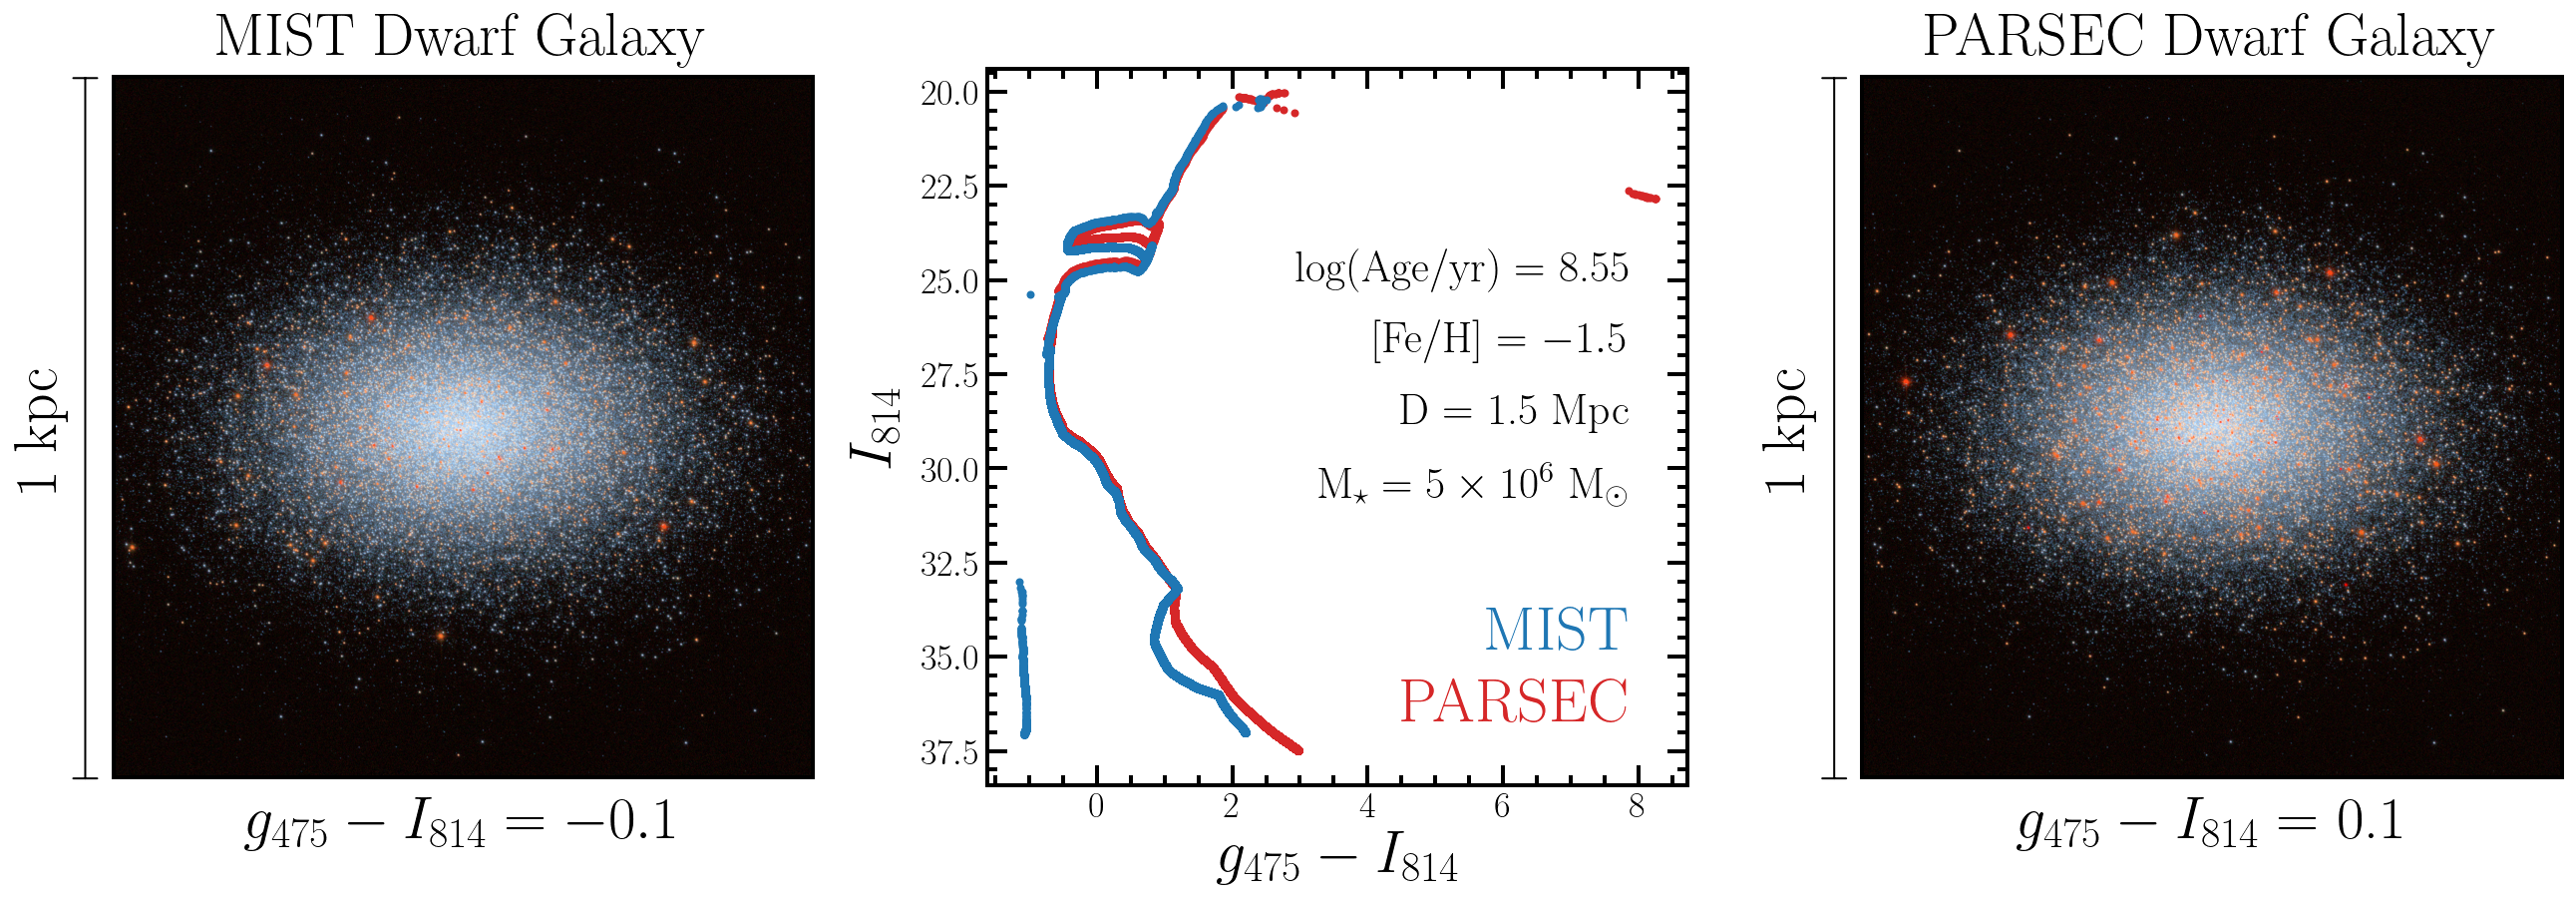

In [13]:
scale = 1.1

fig, ax = plt.subplots(1, 3, figsize=(20*scale, 6*scale))
fig.subplots_adjust(wspace=0.25)

artpop.show_image(mist_rgb, subplots=(fig, ax[0]), rasterized=True)
ax[0].set(xticks=[], yticks=[])

title_fs = 30
ax[0].set_title('MIST Dwarf Galaxy', fontsize=title_fs, pad=11)
ax[0].set_xlabel('$g_{475} - I_{814} = ' + str(round(mist_gI, 1)) + '$', fontsize=title_fs, labelpad=10)


ax[1].plot(g_parsec - I_parsec, I_parsec, '.', c='tab:red', label='PARSEC')
ax[1].plot(g_mist - I_mist, I_mist, '.', c='tab:blue', label='MIST')


x = 0.92
y = 0.21
dy = 0.1
ha = 'right'
ax[1].text(x, y, 'MIST', c='tab:blue', transform=ax[1].transAxes, 
           fontsize=31, ha=ha, va='center')
ax[1].text(x, y - dy, 'PARSEC', c='tab:red', transform=ax[1].transAxes, 
           fontsize=31, ha=ha, va='center')


ax[1].set_ylabel('$I_{814}$', fontsize=30, labelpad=10)
ax[1].set_xlabel('$g_{475} - I_{814}$', fontsize=30)
ax[1].tick_params(labelsize=18)
ax[1].set_ylim(19.4, 38.4)

ax[1].minorticks_on()
ax[1].invert_yaxis()

x = 0.92
y = 0.72
dy = 0.1
dx = 0.3
fs = 22
ha = 'right'

ax[1].text(x, y, 'log(Age/yr) = 8.55', 
           transform=ax[1].transAxes, 
           fontsize=fs, ha=ha, va='center')

ax[1].text(x, y - dy, '[Fe/H] = $-1.5$', 
           transform=ax[1].transAxes, 
           fontsize=fs, ha=ha, va='center')

ax[1].text(x, y - 2 * dy, f'D = {distance.value} Mpc', 
           transform=ax[1].transAxes, 
           fontsize=fs, ha=ha, va='center')

ax[1].text(x, y - 3 * dy, r'M$_\star = 5 \times 10^6$ M$_\odot$', 
           transform=ax[1].transAxes, 
           fontsize=fs, ha=ha, va='center')

ax[0].set_ylabel('1 kpc', fontsize=30, labelpad=23)
ax[0].annotate('', xy=(-0.04, -0.008), xytext=(-0.04, 1.004), xycoords='axes fraction',
               arrowprops=dict(facecolor='black',  arrowstyle='|-|,widthA=0.6,widthB=0.6'))

artpop.show_image(parsec_rgb, subplots=(fig, ax[2]), rasterized=True)
ax[2].set_title('PARSEC Dwarf Galaxy', fontsize=title_fs, pad=11)
ax[2].set_ylabel('1 kpc', fontsize=30, labelpad=23)

ax[2].set(xticks=[], yticks=[])
ax[2].set_xlabel('$g_{475} - I_{814} = $ ' + f'{parsec_gI:.1f}', fontsize=title_fs, labelpad=10)

ax[2].annotate('', xy=(-0.04, -0.008), xytext=(-0.04, 1.004), xycoords='axes fraction',
               arrowprops=dict(facecolor='black',  arrowstyle='|-|,widthA=0.6,widthB=0.6'))
